In [42]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns

LABELS = ['pocket','swing','texting','whatever'] 

### read raw data files and add label colomn by parsing the file name 

In [43]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    data['source']=file  
    for label in LABELS:
        if file.lower().startswith(label.lower()):
            # print 'add label : ', label
            data['label']=label
            data['devicemode'] =  LABELS.index(label)
            return data
    data['label']=LABELS[-1]
    return data

In [44]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [45]:
rdf = loadFiles(r'../raw-data/utf8')

loading files from :  ../raw-data/utf8
loading :  Texting2.csv
loading :  SwingRightPhoneDownScBody.csv
loading :  SwingRight2.csv
loading :  swing3.csv
loading :  swing2.csv
loading :  swing4.csv
loading :  Pocket2.csv
loading :  swingLeftHandPhoneDownScBody.csv
loading :  TextingPointingDorwatd.csv
loading :  PocketLeftAidePhoneDownScBodyLoose.csv


In [46]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,Unnamed: 11,source,label,devicemode
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,NaN,Texting2.csv,texting,2
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,NaN,Texting2.csv,texting,2
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,NaN,Texting2.csv,texting,2
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,NaN,Texting2.csv,texting,2
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,NaN,Texting2.csv,texting,2


In [47]:
rdf.dropna(axis=1,inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78392 entries, 0 to 8755
Data columns (total 14 columns):
time          78392 non-null float64
gfx           78392 non-null float64
gFy           78392 non-null float64
gFz           78392 non-null float64
wx            78392 non-null float64
wy            78392 non-null float64
wz            78392 non-null float64
p             78392 non-null float64
Bx            78392 non-null float64
By            78392 non-null float64
Bz            78392 non-null float64
source        78392 non-null object
label         78392 non-null object
devicemode    78392 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 9.0+ MB


In [48]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,source,label,devicemode
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,Texting2.csv,texting,2
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,2
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,2
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,2
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,2


## preprocessing 
#### todos :lowpass filter , remove dc & normlaize 


## generate features 
#### todos : calculate norm feature for g-force , gyro 
####  avarage norm on sliding window 

In [49]:
rdf['gforce'] = np.sqrt(rdf['gfx']**2 + rdf['gFy']**2 + rdf['gFz']**2) 
rdf['gyro'] = np.sqrt(rdf['wx']**2 + rdf['wy']**2 + rdf['wz']**2) 

In [50]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,source,label,devicemode,gforce,gyro
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,Texting2.csv,texting,2,0.970810,0.18897
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,2,0.970810,0.18897
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,2,1.065977,0.18897
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,2,1.065977,0.18897
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,2,1.065977,0.18897


In [51]:
rdf['mgforce'] = rdf['gforce'].rolling(window=128,center=False).mean()
rdf['mgforce'].fillna(value=rdf['mgforce'].mean(),inplace=True)

rdf['mgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['mgyro'].fillna(value=rdf['mgyro'].mean(),inplace=True)


In [52]:
rdf['vgforce'] = rdf['gforce'].rolling(window=128,center=False).var()
rdf['vgforce'].fillna(value=rdf['vgforce'].mean(),inplace=True)
rdf['vgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['vgyro'].fillna(value=rdf['vgyro'].mean(),inplace=True)

In [53]:
#rdf.dropna(inplace=True)
rdf.drop('source',axis=1).head(10)

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,label,devicemode,gforce,gyro,mgforce,mgyro,vgforce,vgyro
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.1090,978.4330,-8.1848,-38.2660,-21.8094,texting,2,0.970810,0.188970,1.159161,1.833778,0.169561,1.833778
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.1090,978.4330,-8.1085,-37.5809,-22.7829,texting,2,0.970810,0.188970,1.159161,1.833778,0.169561,1.833778
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4330,-8.1085,-37.5809,-22.7829,texting,2,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4330,-8.8348,-37.9395,-21.8979,texting,2,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4193,-8.8348,-37.9395,-21.8979,texting,2,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
5,0.110,-0.0074,0.3477,0.8704,0.1421,0.0603,0.1090,978.4193,-8.8348,-37.9395,-21.8979,texting,2,0.937308,0.188970,1.159161,1.833778,0.169561,1.833778
6,0.115,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-8.8348,-37.9395,-21.8979,texting,2,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
7,0.116,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-8.8348,-37.9395,-21.8979,texting,2,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
8,0.147,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-9.1873,-37.8632,-21.3715,texting,2,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
9,0.169,-0.0013,0.3385,0.9399,0.0855,-0.0155,0.0556,978.4193,-9.1873,-37.8632,-21.3715,texting,2,0.998997,0.103159,1.159161,1.833778,0.169561,1.833778


### visualize

In [54]:
rdf.iloc[0,13]

2

In [55]:
cor_mat = rdf.iloc[:,13:-1].corr()
cor_mat

,devicemode,gforce,gyro,mgforce,mgyro,vgforce
devicemode,1.000000,-0.183810,-0.559687,-0.703884,-0.816942,-0.789486
gforce,-0.183810,1.000000,0.209836,0.209643,0.217479,0.168900
gyro,-0.559687,0.209836,1.000000,0.558408,0.641606,0.538218
mgforce,-0.703884,0.209643,0.558408,1.000000,0.856470,0.643462
mgyro,-0.816942,0.217479,0.641606,0.856470,1.000000,0.786577
vgforce,-0.789486,0.168900,0.538218,0.643462,0.786577,1.000000


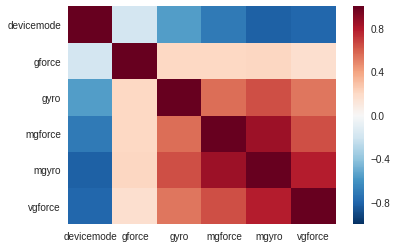

In [56]:
sns.heatmap(cor_mat)

In [57]:
print(rdf.iloc[:,11].value_counts())

swing2.csv                                11819
swingLeftHandPhoneDownScBody.csv          10608
SwingRightPhoneDownScBody.csv              9258
PocketLeftAidePhoneDownScBodyLoose.csv     8756
Pocket2.csv                                8050
SwingRight2.csv                            7244
swing4.csv                                 6784
TextingPointingDorwatd.csv                 6674
swing3.csv                                 4931
Texting2.csv                               4268
Name: source, dtype: int64


Axes(0.125,0.125;0.775x0.755)


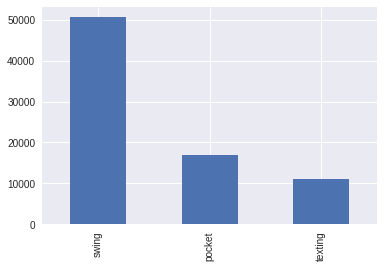

In [58]:
print(rdf.iloc[:,12].value_counts().plot(kind = 'bar'))

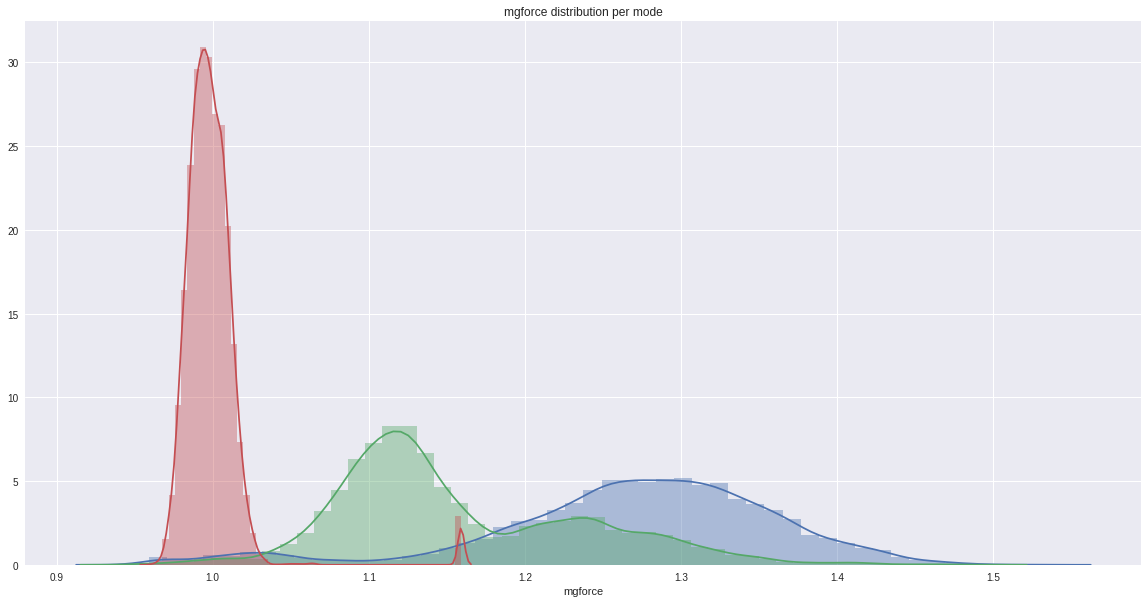

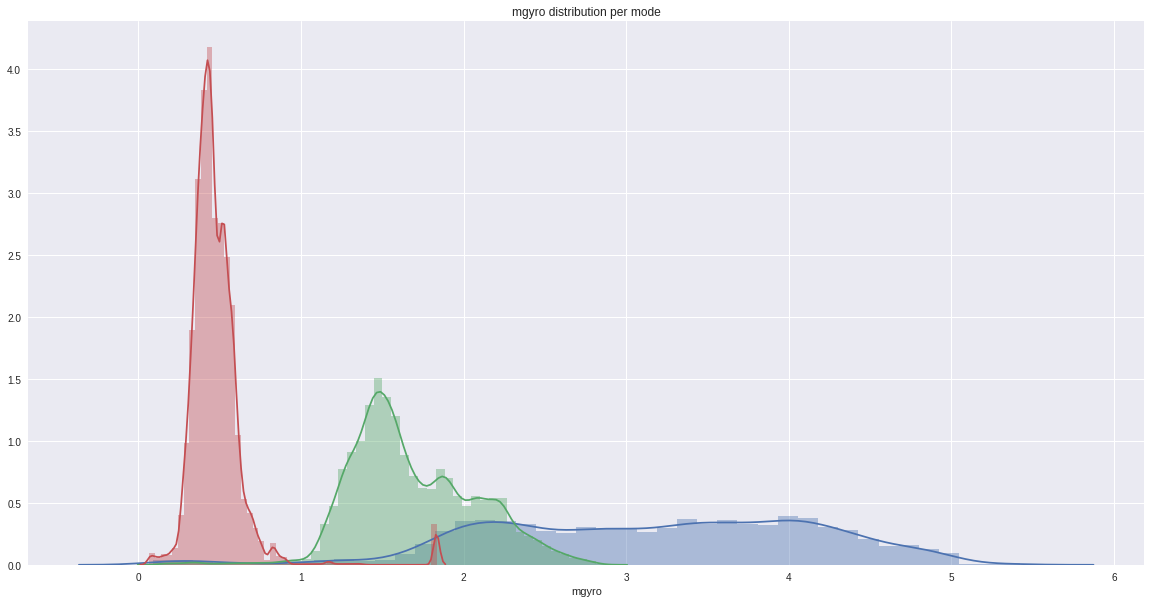

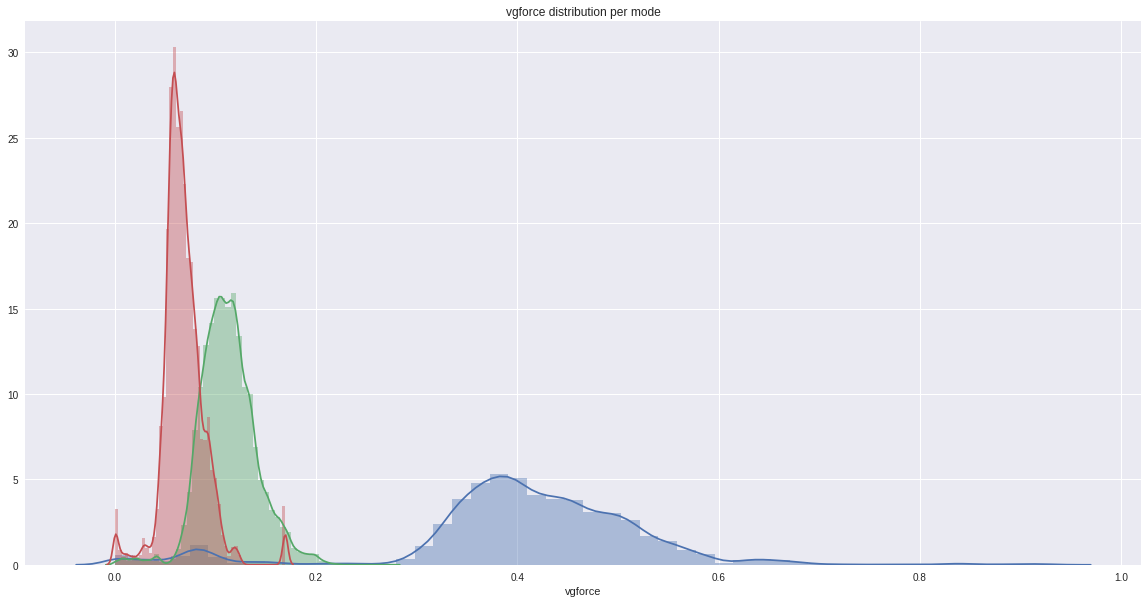

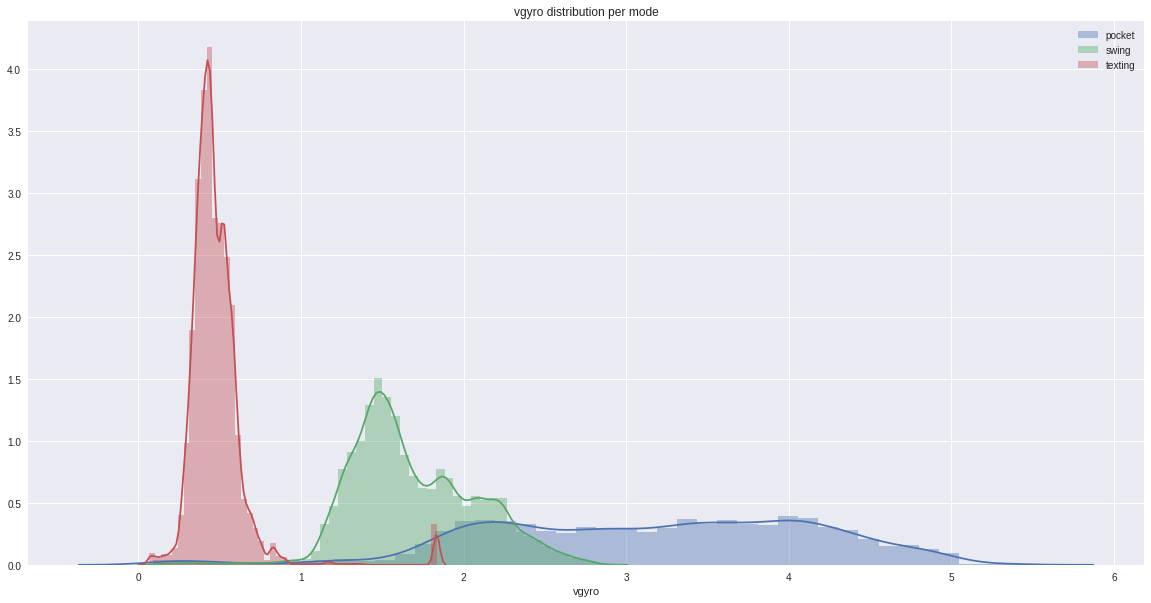

In [59]:
features = ['mgforce','mgyro','vgforce','vgyro']
for f in features:
    plt.figure(figsize=(20,10))
    plt.title(f + " distribution per mode")
    for l in LABELS:    
        if l != 'whatever':
            sns.distplot(rdf[rdf.label == l][f], label=l)
plt.legend()
plt.show()

## split train & test data

In [62]:
from sklearn.model_selection import train_test_split
rdf.drop('source',axis=1,inplace= True)
rdf.drop('label',axis=1,inplace= True)
X_train, X_test, y_train, y_test = train_test_split(rdf, rdf.devicemode, test_size=0.3, random_state=42)


[[ 4953     5     1]
 [    7 15309     0]
 [    0     3  3240]]


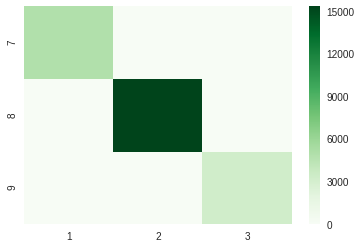

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_jobs=4,n_neighbors=4)
knn.fit(X_train,y_train)
knn4_pred = knn.predict(X_test)
print(confusion_matrix(y_pred=knn4_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn4_pred,y_true=y_test),cmap='Greens')

In [65]:
from sklearn.metrics import classification_report
print('classification report results:\r\n' + classification_report(y_pred=knn4_pred,y_true=y_test))

classification report results:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4959
          1       1.00      1.00      1.00     15316
          2       1.00      1.00      1.00      3243

avg / total       1.00      1.00      1.00     23518

